# bpca_impute: 確率的主成分分析による欠損値補完

**井手剛 (Tsuyoshi Ide)**, tide@us.ibm.com, IBM Thomas J. Watson Research Center

January 1, 2022

このノートブックは下記の論文で提案された欠損値補完手法をオープンソース化した実装を説明するものです。

> Takumi Kitamoto, Tsuyoshi Idé, Yuta Tezuka, Norio Wada, Yui Shibayama, Yuya Tsurutani, Tomoko Takiguchi, Sachiko Suematsu, Kei Omata, Yoshikiyo Ono, Ryo Morimoto, Yuto Yamazaki, Jun Saito, Hironobu Sasano, Fumitoshi Satoh, and Tetsuo Nishikawa,  *Identifying Primary Aldosteronism Patients who Require Adrenal Venous Sampling: A Multi-center Study*, Scientific Reports, 2023, to appear.


プログラムは2つのモジュールからなります。メインは前者です。後者は可視化用のツールを若干含む程度です。
- `bpca_impute`
- `bpca_impute_util`

前者は Numpy にのみ依存しています。主な関数は次の通りです。

- 潜在空間に等方性を仮定する初等的なモデル
    - `em_pca`:
        - これは欠損がないデータ行列に対して主成分を求めます。Sam Roweis, "EM algorithms for PCA and SPCA." Advances in neural information processing systems (1998): 626-632. で提案されたノイズレスの確率的主成分分析モデルを実装したものです。
    - `impute_em_pca`: 
        - 上記の em_pca に、欠損補間機能を組み込んだものです。算法は、欠損値を新たな潜在変数とみなしてベイズ学習の算法を導出することで導いたものです。ノイズレスの極限では、2乗誤差の最小化と一致します。
- 潜在空間の異方性を組み込み、関連度自動選択を可能にした発展的モデル
    - `impute_bpca`: 
        - 潜在次元ごとに分散を計算します。分散がゼロになるとその次元は予測に無関係になります。それにより潜在次元の自動選択ができます。ただし、分散がゼロの場合対数尤度の数値的計算ができなくなるため、代わりに射影行列 $\mathsf{W}$ と欠損値の値の収束を監視します。計算された分散は `Adiag` に格納されています。これがゼロのものをモデルから除くためには、後処理として `shrink_latent_space()` という関数を使います。
    - `impute_bpca_ard`:
        - 上のモデルにおいて、irrelevant と判断された潜在次元を適宜モデルから取り除きます。`shrink_latent_space()` による後処理は不要です。対数尤度も監視できますが、モデルの理論的限界により、対数尤度の計算は必ずしも正確ではありません。欠損値補完が目標であれば、補完された値の収束を監視するのが合理的でしょう。
- その他の関数
    - `impute_transfer`: 
        - 欠損が存在しうる2つのデータセットがある場合に使います。典型的には、テストデータの欠損を埋めるために使います。
    - `recover_components_em_pca`:
        - 射影行列 $\mathsf{W}$ の列空間は主部分空間と一致しますが、一般には列ベクトルは正規直交性を満たさず、主成分とも一致しません。この関数は $\mathsf{W}$ と平均ベクトル $\mathbf{\mu}$ から主成分ベクトルを求めるために使います。


## 開発の背景

欠損値補完の方法は大きく近傍ベースの方法とデータ行列の分解（factorization）によるものに分けられます。主成分分析による欠損値補完手法は後者の代表的なものであり、欠損値を事後分布の形で確率的に予測できるという点において、極めて重要な位置を占めています。

主成分分析はデータの潜在次元をとらえる方法として非常に有名ですが、データ行列に欠損値があった場合はもちろん計算できません。じゃあどうするのか、と思うと思いますが、話は簡単で、**欠損値を仮決めした上で**、主成分を求め、その主成分に基づいて欠損値の再推定を行います。この主成分推定・欠損値推定という2つのステップを繰り返すことで、もっともらしい値を補完する、という筋になります。この理由により、（まともな）欠損値補完の手法のほとんどは反復算法を基本とします。

主成分分析による欠損値補完は多くの著者により研究されてきましたが [Oba et al. 2003] 

> Shigeyuki Oba, Masa-aki Sato, Ichiro Takemasa, Morito Monden, Ken-ichi Matsubara, Shin Ishii, A Bayesian missing value estimation method for gene expression profile data, Bioinformatics, Volume 19, Issue 16, 1 November 2003, Pages 2088–2096 [[link](https://academic.oup.com/bioinformatics/article/19/16/2088/242445)].

により完備された理論が提案され、同時に Matlab による実装を配布したことで、これが決定版となりました。このベイズ的主成分分析に基づく手法は多くの欠損値補完手法のなかで、最も優れたもののひとつとして知られています。比較検討は例えば [Brock et al. 2007] を参照。

> Brock, G.N., Shaffer, J.R., Blakesley, R.E. et al. Which missing value imputation method to use in expression profiles: a comparative study and two selection schemes. BMC Bioinformatics 9, 12 (2008). [[link](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-9-12)]

[Oba et al. 2003] は確率的主成分分析の完全なベイズ的扱いによる欠損値補完の論文で、理論上はある意味完成されているとも言えます。しかし、上記の医学診断の文脈では、次の3つの課題がありました。

1. 多施設の医療データを分析する時、ある（データが豊富に取得できる）施設で作った欠損値補間モデルを、他の（データが乏しい）施設で流用したい。このような **転移学習(transfer learning)** の設定での議論がされていない。
1. モデルの柔軟性・解釈可能性に乏しい。[Oba et al. 2003] のような完全なベイズモデルは既存のPCAに比べ複雑で、中身がブラックボックスになりがちである。等方的な潜在空間を仮定する伝統的なPCAだと、出力は明確であるが、潜在空間の次元を自動的に決められない。実用上は両者の中間が望ましい。
1. Pythonの実装の選択肢が乏しく、実応用上のシステムの組み込みに困難がある。


## 欠損値補完モデルの説明

潜在空間に異方性を仮定するモデルは、次のような生成モデルに基づいています。
$$
p_\mathrm{obs}(\mathbf{x}\mid \mathbf{z}) = 
    \mathcal{N}(\mathbf{x} \mid \mathsf{W}\mathbf{z}+\mathbf{\mu},\epsilon \mathsf{I}_M)
$$ 
$$
p_\mathrm{prior1}(\mathbf{z}) = \mathcal{N}(\mathbf{z} \mid \mathbf{0},\mathsf{I}_d)
$$
$$
p_\mathrm{prior2}(\mathsf{W}) = \prod_{l=1}^d \mathcal{N}(\mathbf{w}_l \mid \mathbf{0}, \alpha_l  \mathsf{I}_M)
$$
ただし一般に、$\mathcal{N}(\mathbf{x} \mid \mathbf{m},\mathsf{\Sigma})$ は、$\mathbf{x}$ についての、平均 $\mathbf{m}$、共分散 $\mathsf{\Sigma}$ の正規分布を表します。等方モデルの方は、$p_\mathrm{prior2}(\mathsf{W})$ という事前分布を省略するため、$\{\alpha_l\}$ についての最適化が発生しません。

各変数の次元は次の通りです。
- 観測変数 $\mathbf{x} \in \mathbb{R}^M$
- 潜在変数 $\mathbf{z} \in \mathbb{R}^d$, $\mathbf{x}$ の欠損部分
- 射影行列 $\mathsf{W}=[\mathbf{w}_1, \ldots, \mathbf{w}_d] \in \mathbb{R}^{M\times d}$

潜在空間から観測空間への射影における分散は考慮するが、観測時の分散は小さい（$\epsilon\rightarrow 0$）と仮定すると、射影行列の事後分布はデルタ関数になります。それにより、$\mathsf{W}$ を点推定の形で明示的に求めることができます。異方モデルでは潜在次元の分散 $\alpha_l$ も定数尤度を最大化することで求められます。

等方モデルと異方モデルの最大の差異は、関連度自動決定機能にあります。等方モデルでは、潜在変数の次元 $d$ は手で決めるしかありません。一方、異方モデルでは、$d$ について何かの事前知識あればもちろんそれを使うべきですが、よくわからない場合はその指定を `n_PCs = None` とすることで**潜在次元を自動決定させる**ことができます。具体的にはその場合、まずは
$$ 
d = \min\{M,N-1\} -1
$$
のような最大限大きな潜在空間が仮定され、反復の各ステップで $\{\alpha_l\}$ の値を推定します*。いくつかは計算の過程でほぼ0に収束し、その結果、生成モデルには寄与しなくなります。これは潜在空間の次元が枝刈りされたということを意味します。主成分分析の自由度および関連度自動決定については、C. Bishop, "Pattern Recognition and Machine Learning," Springer, Chap.12 を参照してください。

*データの中心化（標本平均を0にすること）により、サンプル数は実質的に1つ減り、データの標準化によりさらにもう1つ減る、という見積もり。

### ひとつの訓練データに含まれる欠損を推測する

欠損次元を含むデータが $\mathcal{D}_{\mathrm{train}}\triangleq \{\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)} \}$ と与えられているとすると、異方モデルの尤度を最大化するための算法は次の通りです。

- 初期化。$\mathbf{\mu}$ と欠損部は標本平均、$\mathsf{W}$ はデータ行列のQR分解等で初期化。
- 反復
    - $\mathsf{Z} \leftarrow [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1} \mathsf{W}^\top \mathsf{\Phi}$
    - $\mathsf{W} \leftarrow \mathsf{\Phi} \mathsf{Z}^\top \mathsf{A} [\epsilon\mathsf{I}_d + \mathsf{Z}\mathsf{Z}^\top \mathsf{A}]^{-1} $
    - $\mathbf{\mu} \leftarrow \frac{1}{N}(\mathsf{X} - \mathsf{W}\mathsf{Z}) \mathbf{1}_N$
    - $ \alpha_i = \frac{1}{M} \|\mathbf{w}_i \|^2$ for $i=1,\ldots,d$
    - $x^{(n)}_j = [\mathsf{W} \mathbf{z}^{(n)}+\mathbf{\mu}]_j \quad (\mathrm{missing \ entries})$
-  出力 $\mathsf{X}, \mathsf{W}, \mathsf{Z}, \mathsf{A}, \mathbf{\mu}$

ただし、$\mathsf{X}\triangleq [\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(N)}]$ は観測標本を列ベクトルとして並べたデータ行列（エクセル等では行にサンプルが入りますが、ここでは列がサンプルに対応していますので注意）、$\mathsf{Z}\triangleq [\mathbf{z}^{(1)},\ldots,\mathbf{z}^{(N)}]$ は各標本に対応する潜在変数ベクトルを列ベクトルとする行列、$\mathsf{\Phi} \triangleq [\mathbf{x}^{(1)}-\mathbf{\mu}, \ldots, \mathbf{x}^{(N)}-\mathbf{\mu}]$、さらに、$\mathsf{A} = \mathrm{diag}(\alpha_1, \ldots, \alpha_d)$ です。等方モデルの算法は $\mathsf{A}$ を単位行列に仮定したものに対応します。

上の反復式の一番最後の行から分かる通り、欠損部分の推定式は、$^{(n)}$ に依存しています。これは、観測された部分の個性に応じてカスタマイズされた形で推測されていることを意味しています。単に平均ベクトル $\mathbf{\mu}$ をその推測として使っているのではありません。言い換えると、$\mathbf{x}^{(n)}$ 内の観測された部分からその標本の雰囲気を察し、さらに、他の標本の散らばり方も横目で見ながら、それに応じた修正を加えているということです。

### 別のデータで学習したモデルを援用して欠損値補完をしたい

上の算法は、 $\mathcal{D}_{\mathrm{train}}\triangleq \{\mathbf{x}^{(1)}, \ldots, \mathbf{x}^{(N)} \}$ というデータが与えられた時に、その「中」に含まれる標本の欠損部分を推定する方法でした。では、**訓練データに含まれていない標本の欠測部分を推定する**にはどうすればいいでしょうか。もっとも素朴な方法は、$\mathcal{D}_{\mathrm{train}}$ に新たな標本を付け加えて、新しいデータ集合を作り、再度モデルの推定と欠測部の推定を一からやり直すことです。しかしそれを行うには、手元に、$\mathcal{D}_{\mathrm{train}}$ を持っていなければなりません。画像分類のベンチマークデータならいざ知らず、現実の応用では、訓練データが手元にあるという想定は非現実的といわざるを得ません。

特に問題になるのこういう場合です。ある患者さんの属性と検査結果をまとめたものをベクトル $\mathbf{x}$ としたとして、それを入力にして何らかの診断 $y$ を与える機械学習のモデルを $y = f(\mathbf{x})$ とします。$y$ としては、ガンかどうか、手術を選択すべきかどうか、などです。もしも $\mathbf{x}$ が完全に与えらえていれば単なる代入ですが、一部が欠けていたらどうでしょう。もし自分の病院だけで大量の標本を取得できるならそれを使って欠損補完モデルを作ればいいですが、それが難しい場合は、**他の施設で作ったモデルを援用して自分の病院にカスタマイズされたモデルを作りたい**ところです。しかし他の施設で取得されたデータは個人情報であり、基本的には中身にはアクセスできません。ですが、生データは無理でも、しかし、モデルなら手に入るかもしれません。

まとめると、問題設定は次の通りです。

- $\mathcal{D}_{\mathrm{train}}$ と $\mathcal{D}_{\mathrm{test}}$ という2つのデータセットがある（通常、前者の方がずっと大きい）。
- $\mathcal{D}_{\mathrm{train}}$ と $\mathcal{D}_{\mathrm{test}}$ の**どちらにも**欠損がありうる。
- $\mathcal{D}_{\mathrm{train}}$ の中身を見ることはできないが、それを使って学習した  $\{ \mathsf{W, A}, \mathbf{\mu}\}$ なら手に入る。
- $\mathcal{D}_{\mathrm{test}}$ に含まれる欠損値を埋めたい。


この場合2つのシナリオが考えられます。

### テストデータと訓練データの間で、平均値のずれが小さいと推測される場合

機器の信頼しうるキャリブレーションの方法があれば、$\mathbf{\mu}$ を流用することは許されるでしょう。射影行列の期待値 $\mathsf{W}$ も所与とします。テストデータ $\mathcal{D}_\mathrm{te}$ は $N_\mathrm{te}$ 個の標本を含むとし、そのデータ行列を
$$
\mathsf{X}_\mathrm{te} \triangleq [\mathbf{x}^{[1]}, \ldots, \mathbf{x}^{[N_\mathrm{te}]}]
$$
と置きます。この場合、以下の反復算法により $\mathcal{D}_\mathrm{te}$ に含まれる欠損値を推定できます。

- 初期化。欠損値について $x_j = \mu_j$ と初期化する。
- 反復。$n=1,\ldots,N_\mathrm{te}$ に対し収束まで次を反復。
    - $\mathbf{z}^{[n]} = [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1}\mathsf{W}^\top (\mathbf{x}^{[n]} - \mathbf{\mu})$ 
    - $x_j^{[n]} \leftarrow [\mathsf{W} \mathbf{z}^{[n]}+\mathbf{\mu}]_j$ (欠損値)

### テストデータと訓練データの間で、平均値のずれが存在しうる場合

この場合、$\mathcal{D}_\mathrm{te}$ にカスタマイズされた平均値パラメター $\mathbf{\mu}_\mathrm{te}$ をも推定しなければなりません。$\mathcal{D}_\mathrm{te}$ にある程度のサンプル数があればこれは可能でしょう。この場合、射影行列の期待値 $\mathsf{W}$ のみ所与として、以下の反復算法により $\mathcal{D}_\mathrm{te}$ に含まれる欠損値を推定できます。

- 初期化。欠損値について $x_j = \mu_j$ と初期化する。
- 反復。$n=1,\ldots,N_\mathrm{te}$ に対し収束まで次を反復。
    - $\mathbf{z}^{[n]} = [\epsilon \mathsf{I}_d +\mathsf{W}^\top\mathsf{W}]^{-1}\mathsf{W}^\top (\mathbf{x}^{[n]} - \mathbf{\mu}_\mathrm{te})$ 
    - $\mathbf{\mu}_\mathrm{te} \leftarrow \frac{1}{N}(\mathsf{X}_\mathrm{te} - \mathsf{W}\mathsf{Z}_\mathrm{te}) \mathbf{1}_{N_\mathrm{te}}$
    - $x_j^{[n]} \leftarrow [\mathsf{W} \mathbf{z}^{[n]}+\mathbf{\mu}_\mathrm{te}]_j$ (欠損値)

## デモ1: 単一データの欠損値補完

### データの概観
[Kitamoto et al. 22] で使用したデータを使い、欠損値補完のデモを行います。`df_tr` 訓練データに対応する DataFrame で、各行がひとりの患者のデータに対応します。個人属性に強く関係するいくつかの変数を除き、なおかつ元の値が推測不可能なように、いくつかのランダム化を施しています。最後の8つの変数はカテゴリカル変数をバイナリのダミー変数に変換したものです（いわゆる one-hot encoding）。

このデータには多くの欠損があります。`show_missing_pattern_binary()`を使って欠損パターンを図示したものを下記に示します。特定の変数、特定の患者に偏って欠損が多く発生していることが分かります。

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%time
import pandas as pd
df_tr = pd.read_csv( './data/Xtr.csv')
df_tr

Wall time: 471 ms


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x26,x27,x29_A,x29_B,x29_C,x29_D,x30_A,x30_B,x30_C,x30_D
0,0.448229,-0.649316,0.817186,0.460971,-0.067882,1.825301,-1.427961,0.846719,-0.758353,0.288376,...,-0.361824,0.515343,-0.636500,0.626428,-0.270361,-0.801655,1.657359,-0.707739,-0.084972,-0.801655
1,0.512760,0.063060,0.288533,0.063483,-1.119464,-0.545884,0.395598,1.029512,0.956802,-0.056576,...,-0.361824,-0.111082,0.931137,-0.203804,-0.270361,-0.801655,-0.601199,1.407868,-0.084972,-0.801655
2,-0.583018,0.535236,0.661652,0.589891,0.913594,-0.545884,-0.413345,0.452810,-0.758353,-0.943033,...,-0.777435,-0.688691,0.931137,-0.813177,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
3,-1.241035,-1.605883,0.234015,-1.147130,-0.768937,-0.545884,-0.710092,-0.949770,-0.758353,-0.137068,...,-0.777435,-0.594410,1.127092,-0.149986,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
4,-0.366251,-0.011533,-1.435082,0.654154,-0.278198,-0.545884,-0.115195,-0.538204,-0.758353,-0.261169,...,0.831299,-0.018276,0.147318,-0.097419,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,-0.256864,-0.621154,0.179183,0.989963,0.212540,1.825301,-0.830609,0.767022,-0.758353,-0.144652,...,-0.361824,0.541403,-1.028410,0.643746,-0.270361,-0.801655,1.657359,-0.707739,-0.084972,-0.801655
274,1.058621,0.512598,-1.632597,-0.951289,0.142434,-0.545884,0.152579,1.605883,1.181367,0.488724,...,-0.777435,0.504804,-0.440546,0.236496,-0.270361,-0.801655,-0.601199,1.407868,-0.084972,-0.801655
275,-0.366251,-1.029700,-0.156615,-0.362709,0.282645,-0.545884,0.733970,1.349523,0.323790,0.562782,...,-0.777435,0.214032,-0.636500,0.446870,3.685450,-0.801655,-0.601199,-0.707739,11.726193,-0.801655
276,NaN,NaN,0.234015,0.272060,-0.839042,-0.545884,NaN,NaN,-0.758353,NaN,...,NaN,NaN,-0.636500,NaN,-0.270361,1.242933,-0.601199,-0.707739,-0.084972,1.242933


Wall time: 886 ms


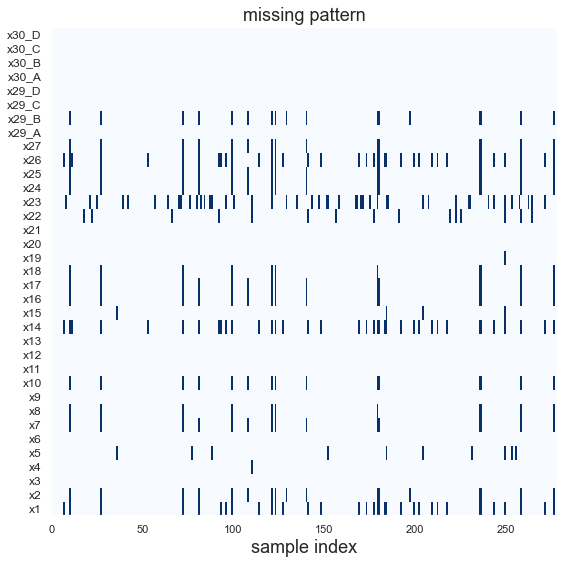

In [3]:
%%time
import bpca_impute.bpca_impute_util as util
_,_ = util.show_missing_pattern_binary(df_tr,figsize=(8,8))

### 訓練データに対する欠損値補完の実行

`impute_bpca()` を使って欠損値補完をしてみます。与えるデータ行列は、**列ベクトル**にサンプルを格納したNumpyアレイです。Pandas DataFrameは受け付けませんので注意してください。この関数は、欠損値が補完されたデータ行列 `X_filled` と、推定されたモデルパラメターを返します。

- `W`: 射影行列
- `Z`: 各標本に対応する潜在空間座標を列ベクトルとして格納した行列。$[\mathbf{z}^{(1)}, \ldots, \mathbf{z}^{(N)}]$
- `Adiag`: 各潜在次元の分散を並べたベクトル。$[\alpha_1, \ldots, \alpha_d]$
- `err_X`: データ行列から欠損部分を抜き出して、ベクトル $\mathbf{g}$ とする。前回の反復ラウンドでの $\mathbf{g}$ と今回の反復ラウンドでの  $\mathbf{g}$ の間の差のノルムを規格化したものに対応。
    $$
    \mathrm{err\_X} = \frac{\|\mathbf{g} -\mathbf{g}_{\mathrm{previous}} \|}{\|\mathbf{g}\|}
    $$
- `err_W`: $\mathsf{W}$ をベクトル化したものを $\mathbf{g}$ とすれば上と同じ。

In [4]:
%%time
import bpca_impute.bpca_impute as bi
X = df_tr.to_numpy().T
X_filled, param = bi.impute_bpca(X)

W = param.get('W')
Z = param.get('Z')
Adiag = param.get('Adiag')
mu = param.get('mu')
err_x = param.get('err_x')
err_W = param.get('err_W')

#samples=278, obs.dim=35, latent dim=34
  50: err_W=0.00030, err_x=0.02204
 100: err_W=0.00024, err_x=0.01065
 150: err_W=0.00021, err_x=0.00678
 200: err_W=0.00019, err_x=0.00486
 250: err_W=0.00017, err_x=0.00372
 300: err_W=0.00016, err_x=0.00297
 350: err_W=0.00015, err_x=0.00245
 400: err_W=0.00014, err_x=0.00206
 450: err_W=0.00014, err_x=0.00176
 500: err_W=0.00013, err_x=0.00152
Finished: itr=500, err_W=0.00013196352930218888, err_x=0.0015244658684705492
Wall time: 1.3 s


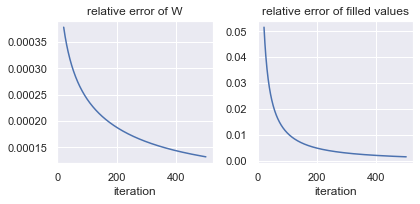

In [5]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
import numpy as np
fig,ax = plt.subplots(1,2,figsize=(6,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(err_x)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],err_W[itr0:]) 
ax[0].set_title('relative error of W')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_x[itr0:]) 
ax[1].set_title('relative error of filled values')
ax[1].set_xlabel('iteration')    
fig.tight_layout()


`Adiag` は $\mathrm{diag}(\alpha_1, \ldots, \alpha_d) $ を意味しています。グラフから、いくつかの値が非常に0に近く、従って、モデルの予測に irrelevant であることが分かります。それらの自由度をモデルから明示的に除外するには `shrink_latent_space()` という関数を使います。

Text(0, 0.5, 'variance of latent dimension')

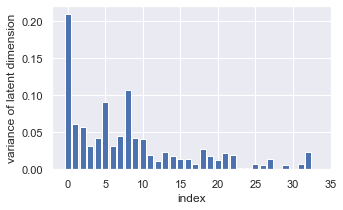

In [6]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(len(Adiag)),Adiag)
ax.set_xlabel('index')
ax.set_ylabel('variance of latent dimension')

Text(0, 0.5, 'variance of latent dimension')

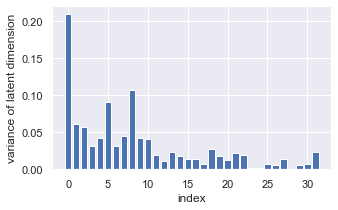

In [7]:
W,Adiag,Z = bi.shrink_latent_space(W,Adiag,Z)

fig,ax = plt.subplots(figsize=(5,3))
ax.bar(np.arange(len(Adiag)),Adiag)
ax.set_xlabel('index')
ax.set_ylabel('variance of latent dimension')

`impute_bpca_ard()` はirrelevant な自由度をモデルから自動で取り除きます。下記のように、
```
itr=0:latent space got shrunk from 34 to 32
```
2つの自由度が自動的に削減されていること分かります。

In [8]:
%%time
X = df_tr.to_numpy().T
X_filled, param = bi.impute_bpca_ard(X)
W = param.get('W')
Z = param.get('Z')
Adiag = param.get('Adiag')
mu = param.get('mu')
err_x = param.get('err_x')
err_W = param.get('err_W')

#samples=278, obs.dim=35, initial latent dim=34
	itr=0:latent space got shrunk from 34 to 32
  50: err_L=0.00020, err_x=0.02204
 100: err_L=0.00012, err_x=0.01065
 150: err_L=0.00009, err_x=0.00678
 200: err_L=0.00007, err_x=0.00486
 250: err_L=0.00006, err_x=0.00372
 300: err_L=0.00005, err_x=0.00297
 350: err_L=0.00005, err_x=0.00245
 400: err_L=0.00004, err_x=0.00206
 450: err_L=0.00004, err_x=0.00176
 500: err_L=0.00003, err_x=0.00152
Finished ARD_BPCA:itr=500, err_L=3.440501484637638e-05, err_x=0.0015244658684732946
Wall time: 833 ms


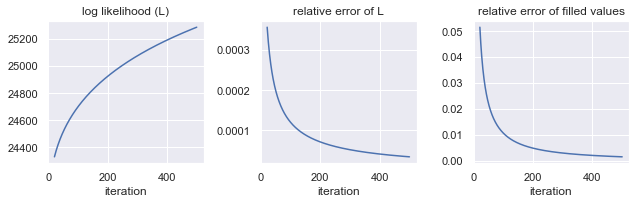

In [9]:
W = param.get('W')
Adiag = param.get('Adiag')
mu = param.get('mu')
loglik = param.get('loglik')
err_x = param.get('err_x')
err_L = param.get('err_L')

fig,ax = plt.subplots(1,3,figsize=(9,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(loglik)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],loglik[itr0:])
ax[0].set_title('log likelihood (L)')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_L[itr0:]) 
ax[1].set_title('relative error of L')
ax[1].set_xlabel('iteration')
ax[2].plot(itr_sequence[itr0:],err_x[itr0:]) 
ax[2].set_title('relative error of filled values')
ax[2].set_xlabel('iteration')    
fig.tight_layout()
    

この手法による欠損値補完と、単純な平均値穴埋めを比較してみます。これだけでどちらが優れているということは言えませんが、BPCA (Bayesian principal component analysis) に基づく方法は周囲とより調和した値を入れる傾向にあることが分かります。

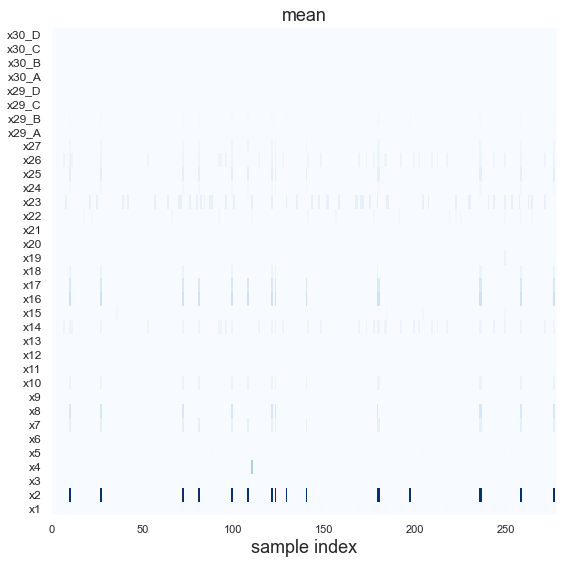

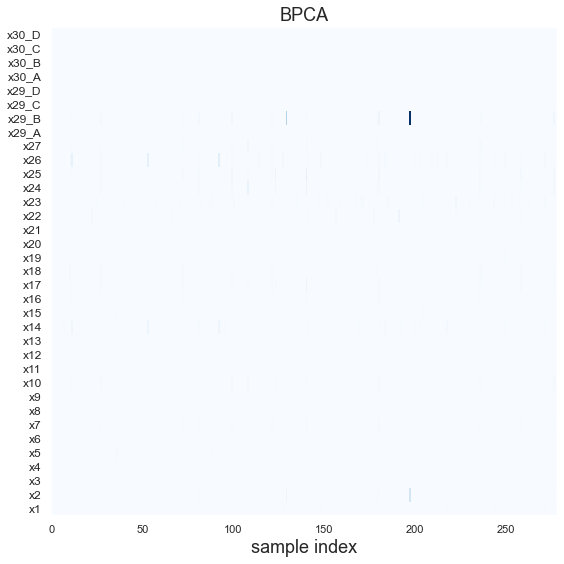

In [10]:
import bpca_impute.bpca_impute_util as util
mask = df_tr.isna()

df_mean_filled = df_tr.fillna(df_tr.mean(axis=0))    
_,_=util.show_missing_pattern(df_mean_filled, mask, title_string='mean',figsize=(8,8)) 

df_filled = pd.DataFrame(X_filled.T,columns=df_tr.columns)
_,_=util.show_missing_pattern(df_filled, mask, title_string='BPCA',figsize=(8,8)) 



## デモ2: 2つのデータを使った欠損値補完の転移学習

今度は先ほど `df_tr` に加えて、別の `df_te` というデータも読んでみます。欠損のパターンは先ほどどずいぶん異なっていることが分かります。

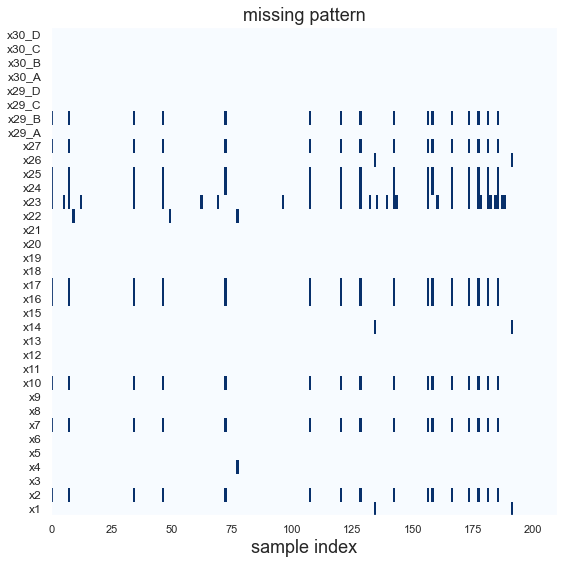

In [11]:
df_te = pd.read_csv( './data/Xte.csv')
_,_ = util.show_missing_pattern_binary(df_te,figsize=(8,8))

このデータに対して転移学習の設定で欠損値補完を行ってみます。

In [12]:
import bpca_impute.bpca_impute as bi
_,param = bi.impute_bpca_ard(df_tr.to_numpy().T)

W = param.get('W')
Adiag = param.get('Adiag')
mu = param.get('mu')


#samples=278, obs.dim=35, initial latent dim=34
	itr=0:latent space got shrunk from 34 to 32
  50: err_L=0.00020, err_x=0.02204
 100: err_L=0.00012, err_x=0.01065
 150: err_L=0.00009, err_x=0.00678
 200: err_L=0.00007, err_x=0.00486
 250: err_L=0.00006, err_x=0.00372
 300: err_L=0.00005, err_x=0.00297
 350: err_L=0.00005, err_x=0.00245
 400: err_L=0.00004, err_x=0.00206
 450: err_L=0.00004, err_x=0.00176
 500: err_L=0.00003, err_x=0.00152
Finished ARD_BPCA:itr=500, err_L=3.440501484637638e-05, err_x=0.0015244658684732946


In [13]:
Xte_imputed, param2 =\
    bi.impute_transfer(df_te.to_numpy().T, W, mu=None,
                                eps=1.e-3, itr_max=1000, 
                                err_L_th=1.e-4,err_x_th=1.e-4)
loglik_test = param2.get('loglik')
err_L_test = param2.get('err_L')
err_x_test = param2.get('err_x')
Z_test = param2.get('Z')

 100: err_L=0.00001, err_x=0.00883
 200: err_L=0.00001, err_x=0.00418
 300: err_L=0.00000, err_x=0.00265
 400: err_L=0.00000, err_x=0.00189
 500: err_L=0.00000, err_x=0.00145
 600: err_L=0.00000, err_x=0.00116
 700: err_L=0.00000, err_x=0.00095
 800: err_L=0.00000, err_x=0.00080
 900: err_L=0.00000, err_x=0.00068
1000: err_L=0.00000, err_x=0.00059
Finished EM_PCA transfer itr=1000,err_L=1.0210275529407966e-06,err_x=0.0005887767699171078


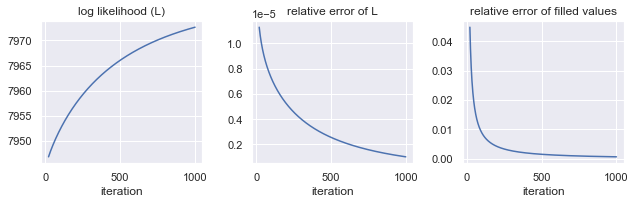

In [14]:
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()
fig,ax = plt.subplots(1,3,figsize=(9,3),sharex=True)
itr_sequence = 1+ np.arange(0,len(loglik_test)) 
itr0 = 20                         
ax[0].plot(itr_sequence[itr0:],loglik_test[itr0:])
ax[0].set_title('log likelihood (L)')
ax[0].set_xlabel('iteration')
ax[1].plot(itr_sequence[itr0:],err_L_test[itr0:]) 
ax[1].set_title('relative error of L')
ax[1].set_xlabel('iteration')
ax[2].plot(itr_sequence[itr0:],err_x_test[itr0:]) 
ax[2].set_title('relative error of filled values')
ax[2].set_xlabel('iteration')    
fig.tight_layout()

(<Figure size 576x576 with 1 Axes>,
 <AxesSubplot:title={'center':'impute_transfer'}, xlabel='sample index'>)

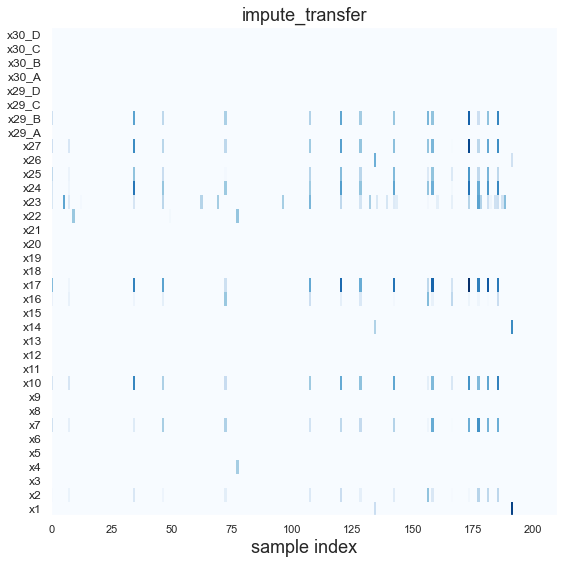

In [15]:
mask = df_te.isna()
df_filled = pd.DataFrame(Xte_imputed.T,columns=df_te.columns)
util.show_missing_pattern(df_filled,mask, title_string='impute_transfer') 
